In [1]:
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
from laplacian_py import laplacian_solver
print(laplacian_solver.__dir__())

res = 100
max_val = res//3

values = .99*max_val*torch.ones((res, res),dtype=torch.float32, device='cuda')
boundary_conditions = torch.zeros((res,res),dtype=torch.float32, device='cuda')
boundary_types = torch.zeros((res,res),dtype=torch.float32, device='cuda')


# obj1_ind1 = int(res*18/30)
# obj1_ind2 = int(res*2/3)
# obj1_ind3 = int(res*0)
# obj1_ind4 = int(res*2/3)
# boundary_conditions[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = max_val
# boundary_types[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = 1.0

# obj2_ind1 = int(res*3/12)
# obj2_ind2 = int(res*4/12)
# obj2_ind3 = int(res*1/3)
# obj2_ind4 = int(res*28/30)
# boundary_conditions[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = max_val
# boundary_types[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = 1.0



cost_scale = .005
cost = cost_scale*torch.ones(res,res,dtype=torch.float32, device='cuda')
safe = res//15
# cost[max(obj1_ind1-safe, 0):min(obj1_ind2+safe, res-1), max(obj1_ind3-safe, 0):min(obj1_ind4+safe, res-1)] = .3
# cost[max(obj2_ind1-safe, 0):min(obj2_ind2+safe, res-1), max(obj2_ind3-safe, 0):min(obj2_ind4+safe, res-1)] = .3


# boundary_conditions[2*60:2*80, 2*60:2*80] = 0
# boundary_types[2*60:2*80, 2*60:2*80] = 1.0

# goals
# ind1 = int(res*2/30)
# ind2 = int(res*2/30)
# boundary_conditions[ind1, ind2] = 0.0
# boundary_types[ind1, ind2] = 1.0
ind1 = int(res*6/30)
ind2 = int(res*22/30)
boundary_conditions[ind1, ind2] = 0.0
boundary_types[ind1, ind2] = 1.0

# inds = np.random.rand(boundary_conditions.shape[0], boundary_conditions.shape[1]) > .999
# boundary_conditions[inds] = 100
# boundary_types[inds] = 1.0

def get_edge_inds(grid_size, dim_index):
    offset = 1
    XYZ = [np.linspace(0, s-1, s, dtype=np.int32) for s in grid_size]
    out = np.meshgrid(*XYZ)
    tmp = np.vstack([val.flatten() for val in out])
    inds1 = tmp[dim_index, :] == 0 + offset
    inds2 = tmp[dim_index, :] == grid_size[dim_index] -1 -offset
    inds = np.any(np.vstack([inds1, inds2]), axis=0)
    return np.reshape(inds, grid_size) 

# edge_inds_x = get_edge_inds(values.shape, 0)
# boundary_conditions[edge_inds_x] = 40
# boundary_types[edge_inds_x] = 1 # flux x

# edge_inds_y = get_edge_inds(values.shape, 1)
# boundary_conditions[edge_inds_y] = 40
# boundary_types[edge_inds_y] = 1 # flux y

XYZ = [np.linspace(0, 1, res, dtype=np.float32) for _ in range(2)]
X, Y = np.meshgrid(*XYZ)
# cost = .005*torch.tensor(10*(1-X)*(1-Y),dtype=torch.float32, device='cuda')





# start = time.time()
# x = np.zeros((100,100),dtype=np.float32)
# for i in range(100000):
#     x = x + 1
# end = time.time()
# print(end - start)




['__name__', '__doc__', '__package__', '__loader__', '__spec__', 'forward', 'backward', '__file__']


In [2]:
from laplacian_py.network import LaplacianSolver

# from torch.autograd import Function
# from torch.autograd.function import once_differentiable

# class LaplacianSolver(Function):
#     @staticmethod
#     def forward(ctx, V: torch.Tensor, C: torch.Tensor):
#         X = torch.stack([V, boundary_types, boundary_conditions, C], axis=2)
#         intermediate = [C] 
#         for i in range(10):
#             intermediate.append(X[:, :, 0].clone())
#             laplacian_solver.forward(X)
#         ctx.save_for_backward(*intermediate)
#         out = X[:, :, 0].clone()    
        
#         return out
    
#     @staticmethod
#     @once_differentiable
#     def backward(ctx, dL_dout):
#         intermediate = ctx.saved_tensors
#         grid_size = intermediate[0].shape
#         dL_dC = torch.zeros(grid_size, dtype=torch.float32, device='cuda')
        
#         C = intermediate[0]
#         dL_dC_i = torch.zeros(grid_size, dtype=torch.float32, device='cuda')
#         dL_dV_i = torch.zeros(grid_size, dtype=torch.float32, device='cuda')
#         dL_dout_i = dL_dout
#         for V in intermediate[-1:0:-1]:
#             X = torch.stack([V, boundary_types, boundary_conditions, C], axis=2)
#             laplacian_solver.backward(X, dL_dout_i, dL_dV_i, dL_dC_i)
#             dL_dC += dL_dC_i
#             dL_dout_i = dL_dV_i
            
#         return dL_dV_i, dL_dC

V =  values
C =  cost

0.0003509521484375


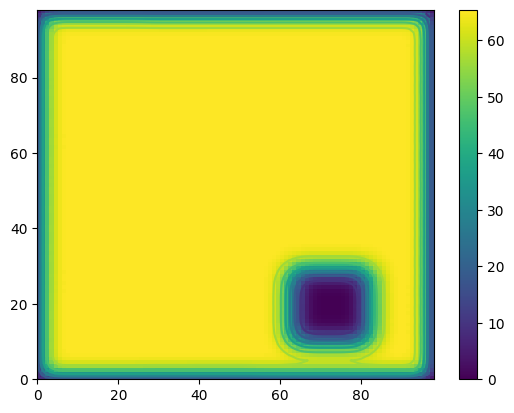

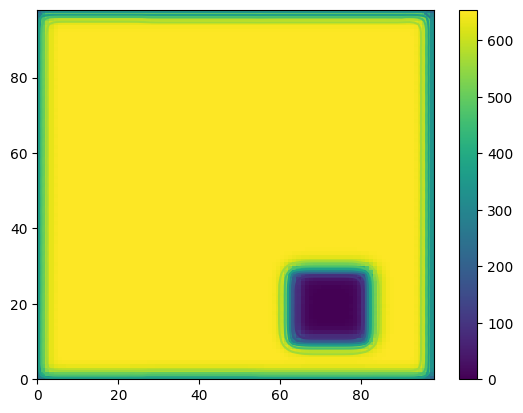

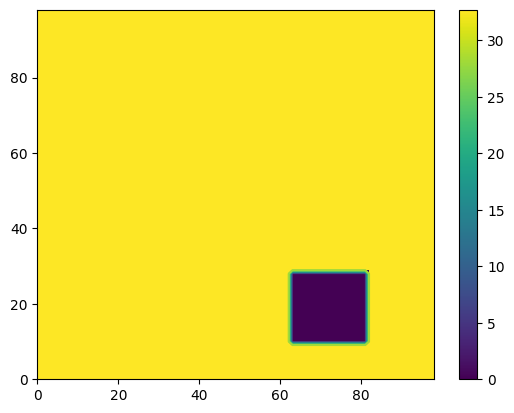

In [3]:
V = V.detach().requires_grad_(True)
C = C.detach().requires_grad_(True)
layer = LaplacianSolver()
forward = layer.apply
start = time.time()
out = forward(V, C, boundary_types, boundary_conditions)

end = time.time()
print(end - start)

loss = torch.sum((out)**2)
loss.backward()

# print(C.grad)
# print(V.grad)
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(V.cpu().detach().numpy())
# print(V.grad.cpu().numpy())

z = V.grad.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z)
plt.colorbar()
plt.contour(z)
plt.show()

z = C.grad.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z)
plt.colorbar()
plt.contour(z)
plt.show()

V = out.detach()

z = V.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z)
plt.colorbar()
plt.contour(z)
plt.show()

# print(torch.cuda.memory_summary() )

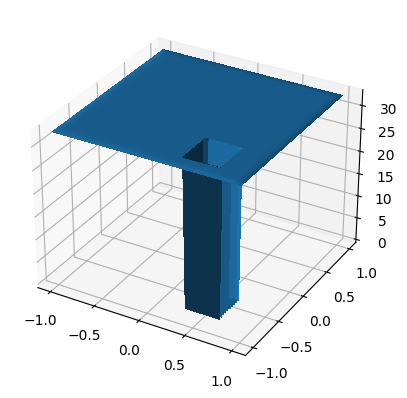

In [4]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.linspace(-1, 1, z.shape[0])
Y = np.linspace(-1, 1, z.shape[1])
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X,Y,z,linewidth=0, antialiased=False)

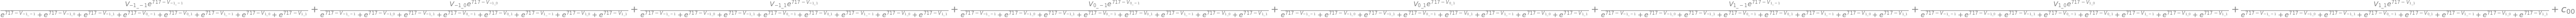

In [5]:
import sympy
from sympy import *

V_s = [symbols('V_{'+f'{i}\_{j}' +'}') for i in [-1,0,1] for j in [-1,0,1] if i!=0 or j!=0]
# V = symbols(f'V00')
c_s = symbols(f'c00')
init_printing(use_unicode=True, wrap_line=False)

expression = c_s + sum([vi*exp(-vi+717)/(sum([exp(-vj+717) for vj in V_s])) for vi in V_s])
expression

d/dV_{-1\_-1}


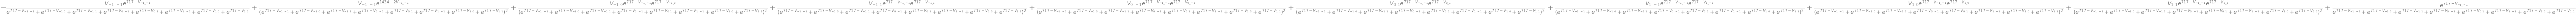

In [6]:
print(f'd/d{V_s[0].name}')
derivative = diff(expression, V_s[0])
derivative

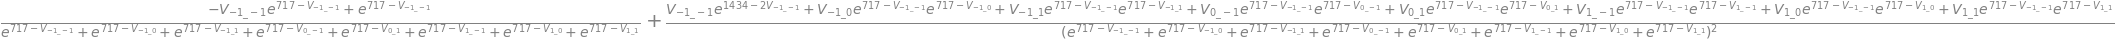

In [7]:
# factor = 1/(sum([exp(-vj) for vj in V_s]))
factor = sum([exp(-vj+717) for vj in V_s])
derivative = sympy.collect(derivative, factor)
# derivative = derivative.simplify()
# derivative = derivative.simplify()
# factor
derivative

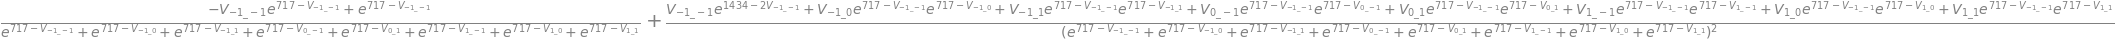

In [8]:
derivative

In [9]:
print('d/dc')
diff(expression, c_s)

d/dc


In [10]:
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim
from laplacian_py.network import LaplaceNet, compute_loss

inds = values >= max_val

# class LaplaceNet(nn.Module):
#     def __init__(self):
#         super(LaplaceNet, self).__init__()
#         self.C = nn.Parameter(cost_scale*torch.ones(res,res,dtype=torch.float32, device='cuda'))
# #         self.V = [max_val*torch.ones((res, res),dtype=torch.float32, device='cuda')]
#         layer = LaplacianSolver()
#         self.solve = layer.apply
        
    
#     def forward(self, x):
# #         C_pos = 5*cost_scale*(torch.tanh(self.C) + 1)
# #         C_pos = cost_scale*(torch.exp(self.C))
#         C_pos = F.relu(self.C)
#         out = self.solve(x, C_pos)
#         out[out >= max_val] = .95*max_val
#         out[inds] = max_val
#         return out, C_pos

# def compute_loss(pred, target, C_pos):
# #     loss = F.huber_loss(pred, target)
#     loss = torch.sum((pred - target)**2)/pred.numel()
#     min_val = .1*cost_scale
#     if torch.any(C_pos[C_pos < min_val]):
#         loss = loss + 50*torch.sum((C_pos[C_pos < min_val] - .1*cost_scale)**2)/torch.sum(C_pos[C_pos < min_val])
#     return loss
    
network = LaplaceNet(res, max_val, cost_scale)
network.cuda(device='cuda')
V_in = V.clone()

tensor(417.9028, device='cuda:0', grad_fn=<DivBackward0>)
tensor(61.9544, device='cuda:0', grad_fn=<DivBackward0>)
tensor(45.4835, device='cuda:0', grad_fn=<DivBackward0>)
tensor(42.2945, device='cuda:0', grad_fn=<DivBackward0>)
tensor(39.5555, device='cuda:0', grad_fn=<DivBackward0>)
tensor(37.2434, device='cuda:0', grad_fn=<DivBackward0>)
tensor(35.2901, device='cuda:0', grad_fn=<DivBackward0>)
tensor(33.6296, device='cuda:0', grad_fn=<DivBackward0>)
tensor(32.2081, device='cuda:0', grad_fn=<DivBackward0>)
tensor(30.9834, device='cuda:0', grad_fn=<DivBackward0>)
tensor(29.9227, device='cuda:0', grad_fn=<DivBackward0>)
tensor(28.9999, device='cuda:0', grad_fn=<DivBackward0>)
tensor(28.1946, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.4898, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.8716, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.3286, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25.8510, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.4306, device='cuda:0

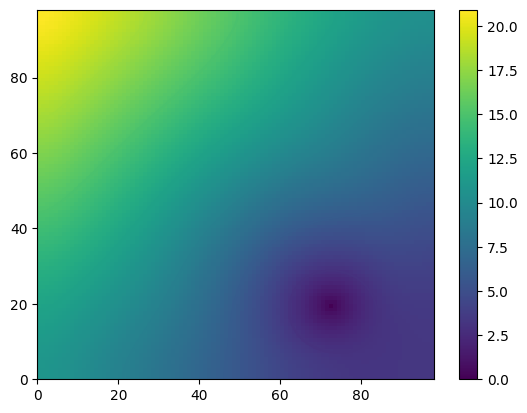

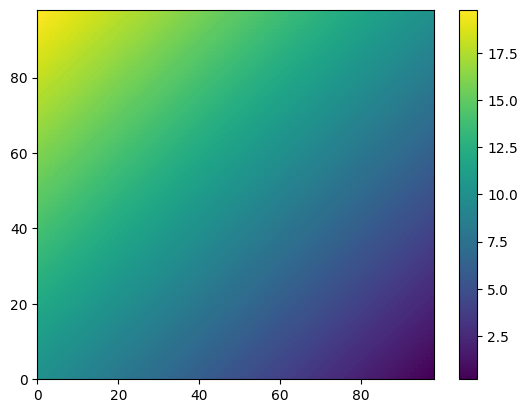

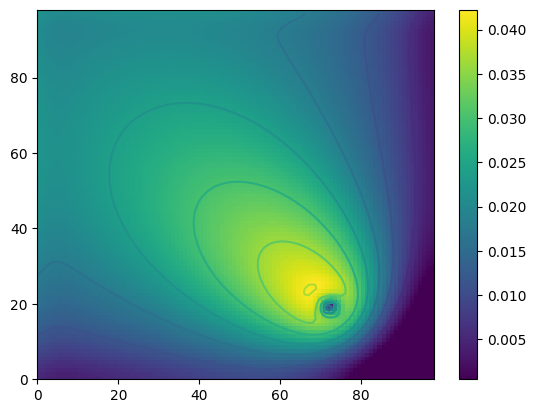

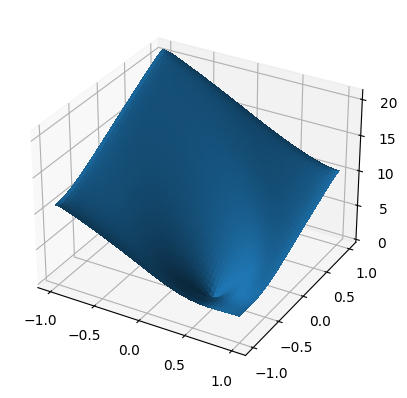

In [11]:
# lr = 5e-0 #huber
# lr = 1e-0 # norm
lr = 1e-5 # norm6

momentum = 0.99

XYZ = [np.linspace(0, 1, res, dtype=np.float32) for _ in range(2)]
X, Y = np.meshgrid(*XYZ)
# target = torch.tensor(20*Y + 0,dtype=torch.float32, device='cuda')
# target = torch.tensor(20*X + 0,dtype=torch.float32, device='cuda')
# target = torch.tensor(12*(X**2+Y**2) + 0,dtype=torch.float32, device='cuda')
# target = torch.tensor(15 + 0*X,dtype=torch.float32, device='cuda')
target = torch.tensor(10*Y + 10*(1-X), dtype=torch.float32, device='cuda')
# target = torch.tensor(10*(1-Y) + 10*X, dtype=torch.float32, device='cuda')

optimizer = optim.SGD(network.parameters(), lr=lr, momentum=momentum)

for it in range(0, 5000):
    optimizer.zero_grad()
    pred, C_pos = network(V_in, boundary_types, boundary_conditions)
    V_in = pred.detach()
    loss_train = compute_loss(pred=pred, target=target, C_pos=C_pos, cost_scale=cost_scale)
    if it % 100 == 0:
        print(loss_train)
    loss_train.backward()
    optimizer.step()
    
    
z = pred.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z)
plt.colorbar()
plt.contour(z)
plt.show()


z2 = target.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z2)
plt.colorbar()
plt.contour(z2)
plt.show()

z3 = C_pos.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z3)
plt.colorbar()
plt.contour(z3)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.linspace(-1, 1, z.shape[0])
Y = np.linspace(-1, 1, z.shape[1])
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X,Y,z,linewidth=0, antialiased=False)


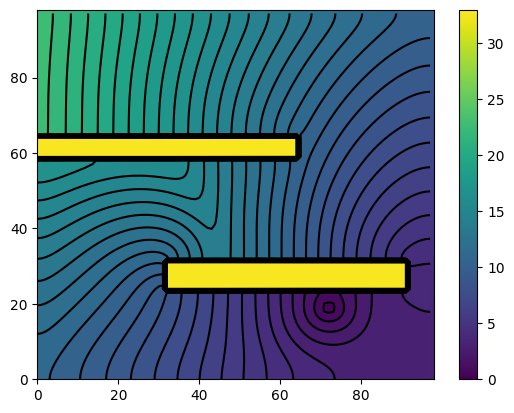

In [12]:
boundary_types_2 = boundary_types.clone()
boundary_conditions_2 = boundary_conditions.clone()

obj1_ind1 = int(res*18/30)
obj1_ind2 = int(res*2/3)
obj1_ind3 = int(res*0)
obj1_ind4 = int(res*2/3)
boundary_conditions_2[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = max_val
boundary_types_2[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = 1.0

obj2_ind1 = int(res*3/12)
obj2_ind2 = int(res*4/12)
obj2_ind3 = int(res*1/3)
obj2_ind4 = int(res*28/30)
boundary_conditions_2[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = max_val
boundary_types_2[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = 1.0


# obj1_ind1 = int(res*1/3)
# obj1_ind2 = int(res*2/3)
# obj1_ind3 = int(res*1/3)
# obj1_ind4 = int(res*2/3)
# boundary_conditions_2[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = max_val
# boundary_types_2[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = 1.0


# boundary_types_2 = boundary_types
# boundary_conditions_2 = boundary_conditions

for i in range(1000):
    pred, C_pos = network(V_in, boundary_types_2, boundary_conditions_2)
    V_in = pred.detach()

z = pred.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z)
plt.colorbar()
cs = plt.contourf(z, levels=list(np.linspace(np.min(z),np.max(z), 50)))
plt.contour(cs, colors='k')
plt.show()




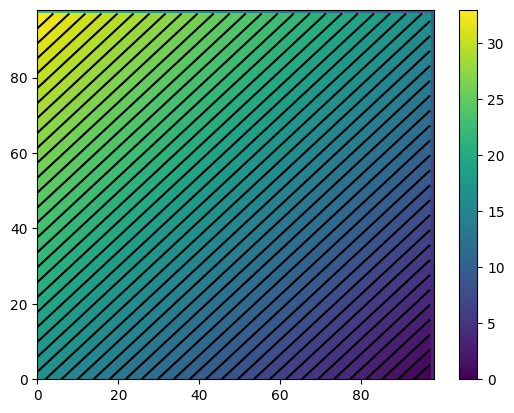

In [13]:
z2 = target.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z)
plt.colorbar()
cs = plt.contourf(z2, levels=list(np.linspace(np.min(z2), np.max(z2), 50)))
plt.contour(cs, colors='k')
plt.show()


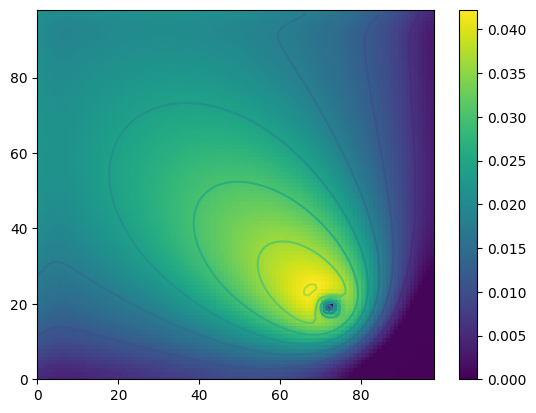

In [14]:
z3 = C_pos.cpu().detach().numpy()[1:-1, 1:-1]
z3[boundary_types[1:-1,1:-1].cpu().numpy() !=0] = 0
plt.pcolormesh(z3)
plt.colorbar()
plt.contour(z3)
plt.show()


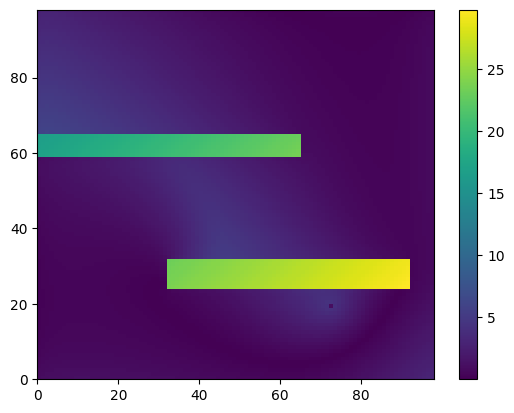

In [15]:
z3 = abs(z2-z)
z3[boundary_types[1:-1,1:-1].cpu().numpy() !=0] = 1
plt.pcolormesh(z3)
plt.colorbar()
plt.show()


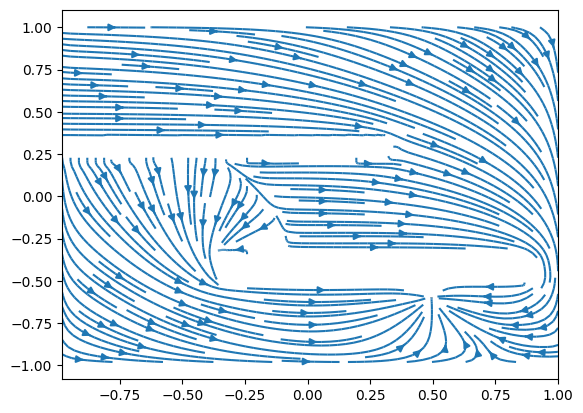

In [16]:
z = pred.cpu().detach().numpy()[1:-1, 1:-1]
Vp = -np.diff(z[:, 1:], axis=0)
Up = -np.diff(z[1:, :], axis=1)
plt.streamplot(X[1:, 1:], Y[1:, 1:], Up, Vp,density=2)

plt.show()

In [17]:
V.shape
torch.stack([V, boundary_types, boundary_conditions, C], axis=2).shape

torch.Size([100, 100, 4])